#### ENEM 2016 - Desafio da semana: prever o valor da nota de matemática para os inscritos no ENEM 2016.

In [73]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns



import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12, 8)
sns.set()

try:
    sklearn.set_config(display='diagram')
except:
    pass

#### Importando as bases de treino e teste 

In [3]:
training = pd.read_csv("train.csv", nrows = 0, index_col = 0)
print('O número de features presentes no train.set :', training.shape[1])

O número de features presentes no train.set : 166


In [4]:
test = pd.read_csv("test.csv")
print('O número de features presentes no test.set :', test.shape[1])

O número de features presentes no test.set : 47


### EDA

Como há muito mais features no conjunto de treino, do que no conjunto de testes, como um modelo baseline, vamos apenas importar as colunas presentes no arquivo de teste.

In [5]:
cols = test.columns.tolist()
cols.append('NU_NOTA_MT')
cols

['NU_INSCRICAO',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'IN_TREINEIRO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'CO_PROVA_CN',
 'CO_PROVA_CH',
 'CO_PROVA_LC',
 'CO_PROVA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047',
 'NU_NOTA_MT']

In [6]:
training = pd.read_csv("train.csv", usecols = cols)
training.sample(5).T

,2283,11664,5407,324,9849
NU_INSCRICAO,f880e3a3daf7772be6279602a565f75c7d4e0377,8494036b7902b61aaab9ba532a2d2e17d220b710,31a2715c7c5f06a5de86b43b47bf854e6373ec53,db8a097f3c3c131f6ebd18827ea877aa73a5786f,114aca09c0d021c07d12582bfa58ce3bf51b6c05
CO_UF_RESIDENCIA,50,31,35,43,35
SG_UF_RESIDENCIA,MS,MG,SP,RS,SP
NU_IDADE,34,17,25,27,18
TP_SEXO,F,F,M,M,F
TP_COR_RACA,3,1,3,1,1
TP_NACIONALIDADE,1,1,1,1,1
TP_ST_CONCLUSAO,1,3,2,1,2
TP_ANO_CONCLUIU,10,0,0,5,0
TP_ESCOLA,1,1,2,1,2


Como temos que desenvolver um algoritmo prever a nota de matemática, utilizando apenas o arquivo de treino, a partir deste ponto, só voltaremos a usar o test set, só no final para fazer o arquivo de resposta de submissão.

#### Análise de dados faltantes - pre-processing

In [7]:
completude = pd.DataFrame({
        'colunas' : training.columns,
        'tipo'    : training.dtypes,
        'missing' : training.isna().sum(),
        'size'    : training.shape[0],
        'unicos'  : training.nunique()
})

completude['percentual'] = round(completude['missing'] / completude['size'], 2)

In [8]:
completude.sample(48)

,colunas,tipo,missing,size,unicos,percentual
NU_NOTA_COMP3,NU_NOTA_COMP3,float64,3597,13730,12,0.26
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,3597,13730,9,0.26
CO_PROVA_CN,CO_PROVA_CN,object,0,13730,10,0.00
Q026,Q026,object,0,13730,3,0.00
Q006,Q006,object,0,13730,17,0.00
TP_ESCOLA,TP_ESCOLA,int64,0,13730,4,0.00
IN_IDOSO,IN_IDOSO,int64,0,13730,2,0.00
IN_BAIXA_VISAO,IN_BAIXA_VISAO,int64,0,13730,2,0.00
TP_PRESENCA_CH,TP_PRESENCA_CH,int64,0,13730,3,0.00
TP_LINGUA,TP_LINGUA,int64,0,13730,2,0.00


Podemos dropar a coluna com número de inscrição que ela não agrega nenhuma informação neste momento.

In [9]:
training.drop(['NU_INSCRICAO'], axis = 1, inplace = True)

In [10]:
training.shape

(13730, 47)

Vamos descartar as linhas aonde a nota de matemática é nula, não podemos usar essas linhas para prever a nota de matemática em novos dados.

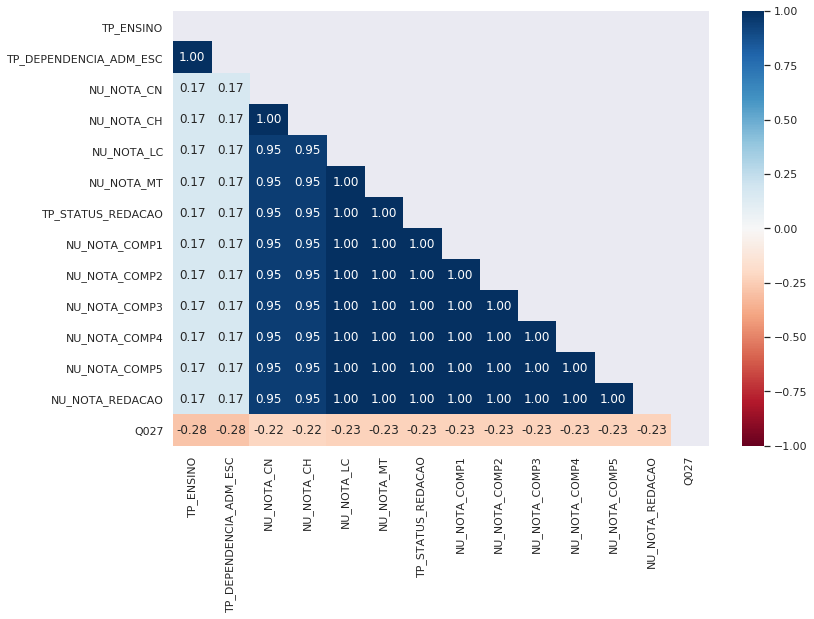

In [11]:
corr = training.isna().corr()
cols = corr.columns[corr.count()>0]
corr = corr.loc[cols, cols]
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap = 'RdBu', annot = True, vmin = -1, vmax=1, \
            fmt = '.2f')

Podemos observar que a falta das notas de redação ou de LC, a nota de matemática também, está indicando que o candidato não foi fazer a prova do segundo dia.

In [12]:
train = training.copy()
# Simplesmente dropando toda a linha aonde a variável target tem valor NaN na coluna 'NU_NOTA_MT'
training.dropna(subset = ['NU_NOTA_MT'], axis = 0, inplace = True)

# resetando o index, porque algumas linhas foram descartadas
training.reset_index(drop = True, inplace = True)

In [13]:
training.sample(5)

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
7981,31,MG,18,F,3,1,1,2,1,NaN,...,40.0,440.0,E,E,B,B,B,C,B,A
3900,32,ES,19,M,1,1,2,0,2,1.0,...,80.0,520.0,B,B,E,B,A,A,NaN,A
5878,12,AC,39,F,1,1,1,10,1,NaN,...,0.0,200.0,B,A,G,A,A,B,B,A
3521,23,CE,17,F,3,1,2,0,2,1.0,...,120.0,640.0,G,G,B,A,A,A,NaN,A
2588,41,PR,33,M,1,1,3,0,1,NaN,...,100.0,420.0,E,D,F,B,B,C,E,A


In [14]:
completude = pd.DataFrame({
        'colunas' : training.columns,
        'tipo'    : training.dtypes,
        'missing' : training.isna().sum(),
        'size'    : training.shape[0],
        'unicos'  : training.nunique()
})

completude['percentual'] = round(completude['missing'] / completude['size'], 2)

In [15]:
completude.head(47)

,colunas,tipo,missing,size,unicos,percentual
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,0,10133,27,0.00
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,10133,27,0.00
NU_IDADE,NU_IDADE,int64,0,10133,53,0.00
TP_SEXO,TP_SEXO,object,0,10133,2,0.00
TP_COR_RACA,TP_COR_RACA,int64,0,10133,6,0.00
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,0,10133,5,0.00
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,0,10133,4,0.00
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,10133,11,0.00
TP_ESCOLA,TP_ESCOLA,int64,0,10133,4,0.00
TP_ENSINO,TP_ENSINO,float64,6494,10133,3,0.64


In [16]:
print('Colunas que serão descartadas por terem muitos dados faltantes \n', completude[completude['percentual'] > 0.50]['colunas'])

Colunas que serão descartadas por terem muitos dados faltantes 
 TP_ENSINO                              TP_ENSINO
TP_DEPENDENCIA_ADM_ESC    TP_DEPENDENCIA_ADM_ESC
Q027                                        Q027
Name: colunas, dtype: object


In [17]:
training.drop(['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'Q027'], axis = 1,\
              inplace = True)

In [18]:
completude = pd.DataFrame({
        'colunas' : training.columns,
        'tipo'    : training.dtypes,
        'missing' : training.isna().sum(),
        'size'    : training.shape[0],
        'unicos'  : training.nunique()
})

completude['percentual'] = round(completude['missing'] / completude['size'], 2)
completude.head(44)

,colunas,tipo,missing,size,unicos,percentual
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,0,10133,27,0.0
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,10133,27,0.0
NU_IDADE,NU_IDADE,int64,0,10133,53,0.0
TP_SEXO,TP_SEXO,object,0,10133,2,0.0
TP_COR_RACA,TP_COR_RACA,int64,0,10133,6,0.0
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,0,10133,5,0.0
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,0,10133,4,0.0
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,10133,11,0.0
TP_ESCOLA,TP_ESCOLA,int64,0,10133,4,0.0
IN_TREINEIRO,IN_TREINEIRO,int64,0,10133,2,0.0


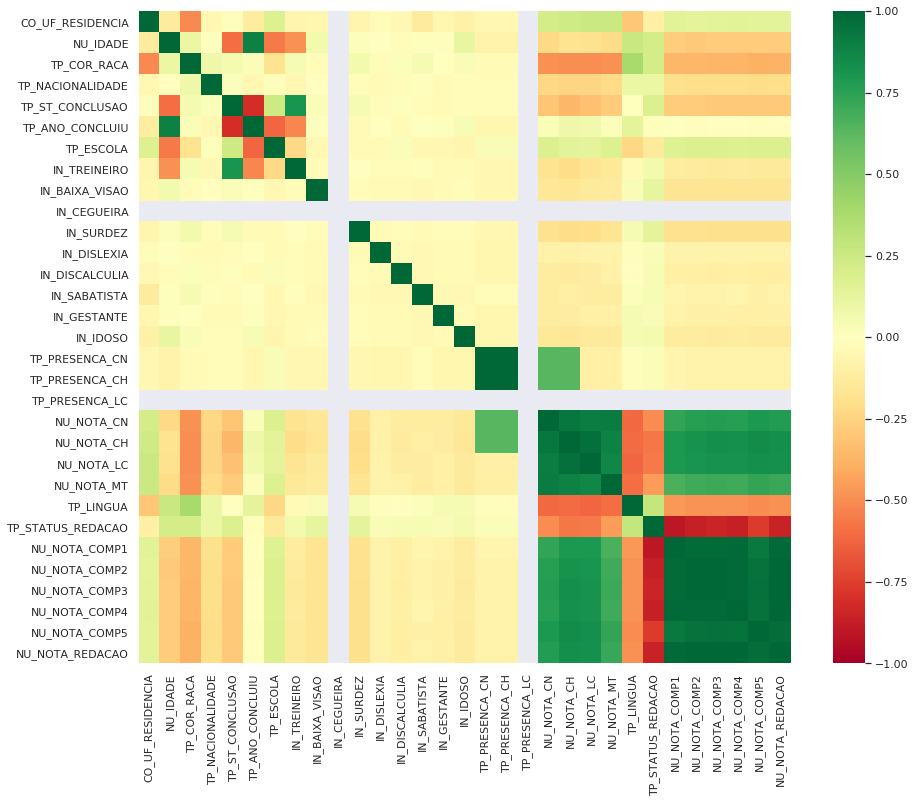

In [19]:
cor_matrix = training.corr()
fig, ax = plt.subplots(figsize = (15, 12))
sns.heatmap(cor_matrix.corr(), square = True, cmap = 'RdYlGn', vmin = -1, \
            vmax=1, fmt = '.2f',ax = ax)
plt.show()
plt.close()

In [20]:
# Numerical features
training_num = training.select_dtypes(include = [np.number])
num_list = training_num.columns.tolist()
num_list.remove('NU_NOTA_MT')
print('As features numericas que serão usadas no modelo 1:\n', num_list)

As features numericas que serão usadas no modelo 1:
 ['CO_UF_RESIDENCIA', 'NU_IDADE', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'IN_TREINEIRO', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']


In [21]:
X = training_num.drop('NU_NOTA_MT', axis = 1)
y = training_num['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [22]:
num_tr= Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors = 3, weights = 'uniform')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers =[
    ('num', num_tr, num_list),
])


model1 = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('linear_model', LinearRegression())
])

In [23]:
model1.fit(X_train, y_train)
train_score = model1.score(X_train, y_train)
print('Training_score: ', train_score)

y_preds = model1.predict(X_test)
# Compute and print r2 and RMSE

print('Testing score: {}'.format(r2_score(y_test, y_preds)))
print('MAE:', mean_absolute_error(y_test, y_preds))

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print('Root Mean Squared Error: {}'.format(rmse))

Training_score:  0.4164861875036771
Testing score: -65059478832019.805
MAE: 17678995.489387374
Root Mean Squared Error: 795944810.3174566


In [24]:
y_preds = model1.predict(test)
answer = pd.DataFrame({
    'NU_INSCRICAO'  :   test['NU_INSCRICAO'],
    'NU_NOTA_MT'    :   y_preds
})
answer.sample(10)

,NU_INSCRICAO,NU_NOTA_MT
3759,8b1d9baf2ce110da189bdc97492dbfe0695c86aa,4.942232e+08
1026,d43c8bc37d22f63102d62317b61cbcdb1331054c,5.750553e+02
1148,9b19bbaedd6ecaef988bef930c5793119b19dc00,4.256256e+02
3765,05cf942d421a1328096dd41aa129871a0f151617,4.510396e+02
1243,7f9879b40a268318e2a969e73156aa9df7a48c13,5.427584e+02
2057,c4eb327e6618f5c7126ffce95fd7a346ed95606f,4.507740e+02
4450,4ddc39ddcca2c01ee310e6153658564d07d69a63,5.304303e+02
3782,cea2d68d8a866c40bbf04cf59dfab64ab5728f0c,4.942232e+08
997,f94f945618e9047bdde48cc06cc7a6e0af719a37,4.040865e+02
4566,ff617d0a9dcb32a68dc35b18ad222fc4a2fb21dc,4.834146e+02


In [25]:
corr_matrix = training_num.corr()
corr_matrix['NU_NOTA_MT'].sort_values(ascending = False)

NU_NOTA_MT           1.000000
NU_NOTA_CN           0.584941
NU_NOTA_CH           0.529594
NU_NOTA_LC           0.494695
NU_NOTA_REDACAO      0.379376
NU_NOTA_COMP3        0.350307
NU_NOTA_COMP5        0.343337
NU_NOTA_COMP4        0.342282
NU_NOTA_COMP2        0.335638
NU_NOTA_COMP1        0.299402
CO_UF_RESIDENCIA     0.107493
TP_ESCOLA            0.069304
TP_ANO_CONCLUIU      0.029039
IN_DISCALCULIA       0.009813
TP_PRESENCA_CH       0.003552
TP_PRESENCA_CN       0.003552
IN_DISLEXIA          0.001453
IN_BAIXA_VISAO       0.000685
IN_GESTANTE         -0.000945
IN_IDOSO            -0.011336
IN_SURDEZ           -0.015249
IN_SABATISTA        -0.016459
IN_TREINEIRO        -0.022287
TP_NACIONALIDADE    -0.034965
TP_STATUS_REDACAO   -0.059376
NU_IDADE            -0.061485
TP_ST_CONCLUSAO     -0.087869
TP_COR_RACA         -0.157364
TP_LINGUA           -0.201726
IN_CEGUEIRA               NaN
TP_PRESENCA_LC            NaN
Name: NU_NOTA_MT, dtype: float64

In [26]:
training_2 = training[['NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',\
                      'NU_NOTA_REDACAO', 'NU_NOTA_COMP5', 'NU_NOTA_COMP4',\
                      'NU_NOTA_COMP3', 'NU_NOTA_COMP2', 'NU_NOTA_COMP1']]
training_2.describe().T

,count,mean,std,min,25%,50%,75%,max
NU_NOTA_MT,10133.0,482.497928,99.826323,0.0,408.9,461.2,537.6,952.0
NU_NOTA_CN,10097.0,473.912509,71.098468,0.0,420.1,460.4,515.1,806.4
NU_NOTA_CH,10097.0,530.346123,73.528309,0.0,481.0,532.6,581.9,807.0
NU_NOTA_LC,10133.0,516.472841,68.688190,0.0,468.1,520.9,564.9,763.6
NU_NOTA_REDACAO,10133.0,529.048258,154.294758,0.0,440.0,540.0,600.0,1000.0
NU_NOTA_COMP5,10133.0,77.372446,43.067140,0.0,40.0,80.0,100.0,200.0
NU_NOTA_COMP4,10133.0,113.123951,33.480033,0.0,100.0,120.0,120.0,200.0
NU_NOTA_COMP3,10133.0,106.824238,34.341349,0.0,80.0,120.0,120.0,200.0
NU_NOTA_COMP2,10133.0,111.915918,33.737588,0.0,100.0,120.0,120.0,200.0
NU_NOTA_COMP1,10133.0,119.811704,29.846017,0.0,120.0,120.0,140.0,200.0


In [27]:
num_list = training_2.columns.tolist()
num_list.remove('NU_NOTA_MT')
print('As features numericas que serão usadas no modelo 1:\n', num_list)

As features numericas que serão usadas no modelo 1:
 ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_COMP5', 'NU_NOTA_COMP4', 'NU_NOTA_COMP3', 'NU_NOTA_COMP2', 'NU_NOTA_COMP1']


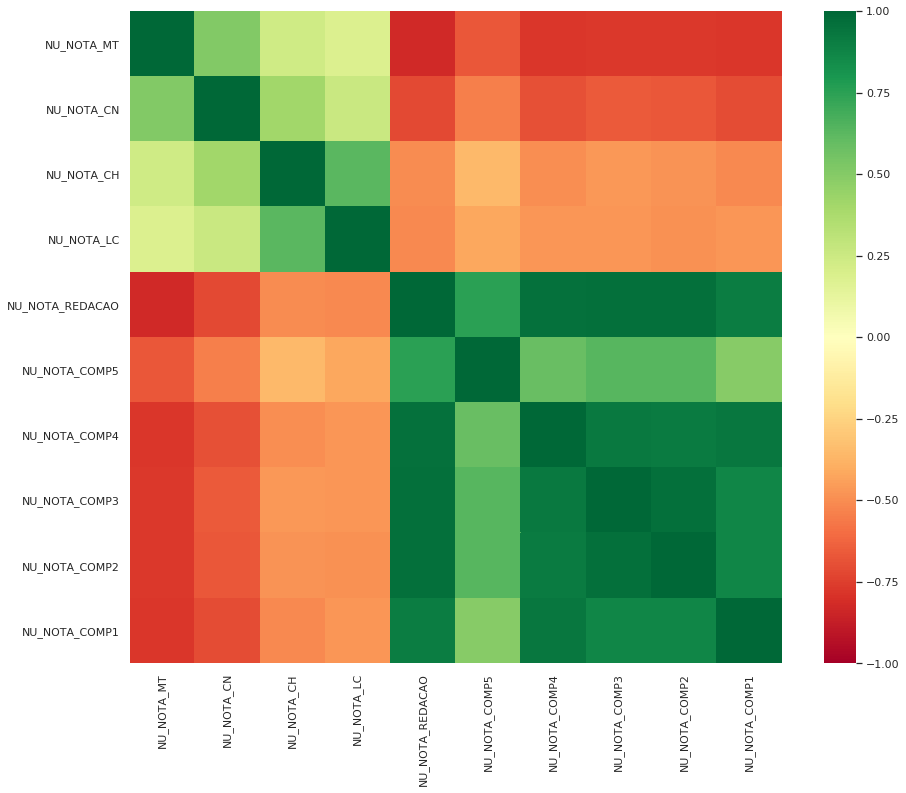

In [28]:
corr_matrix = training_2.corr()
fig, ax = plt.subplots(figsize = (15, 12))
sns.heatmap(corr_matrix.corr(), square = True, cmap = 'RdYlGn', vmin = -1, \
            vmax=1, fmt = '.2f',ax = ax)
plt.show()
plt.close()

In [29]:
X = training_2.drop('NU_NOTA_MT', axis = 1)
y = training_2['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [30]:
num_tr= Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors = 3, weights = 'uniform')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers =[
    ('num', num_tr, num_list),
])


model2 = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('linear_model', LinearRegression())
])

In [31]:
model2.fit(X_train, y_train)
train_score = model2.score(X_train, y_train)
print('Training score - R2: ', train_score)

y_preds = model2.predict(X_test)
# Compute and print r2 and RMSE

print('Testing score - R2: {}'.format(r2_score(y_test, y_preds)))
print('MAE:', mean_absolute_error(y_test, y_preds))

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print('RMSE: {}'.format(rmse))

Training score - R2:  0.4090138762606219
Testing score - R2: 0.368484871673016
MAE: 61.617551568433
RMSE: 78.4186830989281


In [32]:
y_preds = model2.predict(test)
answer = pd.DataFrame({
    'NU_INSCRICAO'  :   test['NU_INSCRICAO'],
    'NU_NOTA_MT'    :   y_preds
})
answer.sample(10)

,NU_INSCRICAO,NU_NOTA_MT
647,637910335d12cc974f839c75dc088a4b8d6b18d3,482.961938
1992,00bce7ff86ba11e2b851d17b6646cf3ea02a04e1,428.658647
3022,c0e056e6a7e9d9a60e0544ab7ffc8479865f1565,458.146196
3136,87d03ec4a277f52567da9b37e0a5cd5801acbebd,511.353960
4163,489533700e5aaf4df4bf2ff5f8a33ae7afcef8f0,539.752397
2624,c5a416e9d46068859aa2aba316db0653b8bfe95d,420.478960
3753,f64ef391c8560402e96a9cc926483c72aebb3e8e,482.961938
2022,4ea4f25a8d880bc41dc2ac3f02d07350bdc08387,519.177446
1327,d0c7acbad13d292e637f23633da232e29186e20c,469.333696
4274,f749db494a6a490fb380f470bb2e937f0128ea25,482.961938


In [33]:
answer.to_csv('answer.csv', index = False)

In [34]:
training_3 = training[['NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',\
                      'NU_NOTA_REDACAO']]
training_3.describe().T

,count,mean,std,min,25%,50%,75%,max
NU_NOTA_MT,10133.0,482.497928,99.826323,0.0,408.9,461.2,537.6,952.0
NU_NOTA_CN,10097.0,473.912509,71.098468,0.0,420.1,460.4,515.1,806.4
NU_NOTA_CH,10097.0,530.346123,73.528309,0.0,481.0,532.6,581.9,807.0
NU_NOTA_LC,10133.0,516.472841,68.688190,0.0,468.1,520.9,564.9,763.6
NU_NOTA_REDACAO,10133.0,529.048258,154.294758,0.0,440.0,540.0,600.0,1000.0


In [35]:
num_list = training_3.columns.tolist()
num_list.remove('NU_NOTA_MT')
print('As features numericas que serão usadas no modelo 1:\n', num_list)

As features numericas que serão usadas no modelo 1:
 ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']


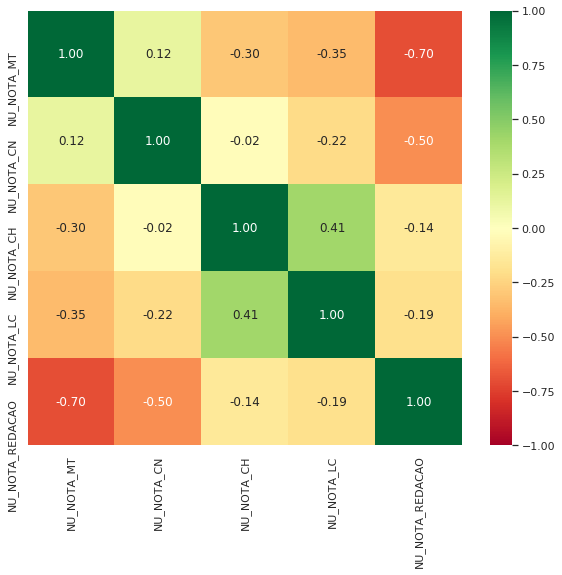

In [36]:
corr_matrix = training_3.corr()
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr_matrix.corr(), square = True, cmap = 'RdYlGn', vmin = -1, \
            vmax=1, fmt = '.2f',annot = True,ax = ax)
plt.show()
plt.close()

In [37]:
X = training_3.drop('NU_NOTA_MT', axis = 1)
y = training_3['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [38]:
num_tr= Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors = 3, weights = 'uniform')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers =[
    ('num', num_tr, num_list),
])


model3 = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('linear_model', LinearRegression())
])

In [39]:
model3.fit(X_train, y_train)
train_score = model3.score(X_train, y_train)
print('Training score - R2: ', train_score)

y_preds = model3.predict(X_test)
# Compute and print r2 and RMSE

print('Testing score - R2: {}'.format(r2_score(y_test, y_preds)))
print('MAE:', mean_absolute_error(y_test, y_preds))

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print('RMSE: {}'.format(rmse))

Training score - R2:  0.40791049852074546
Testing score - R2: 0.37315250828467084
MAE: 61.408624065640375
RMSE: 78.12834264752932


In [40]:
y_preds = model2.predict(test)
answer = pd.DataFrame({
    'NU_INSCRICAO'  :   test['NU_INSCRICAO'],
    'NU_NOTA_MT'    :   y_preds
})
answer.sample(10)

,NU_INSCRICAO,NU_NOTA_MT
1512,901027c8d499d895e0022de833e1a05800e0dff9,467.521196
214,421eb738f9e2ea73e5f4227c915762d6421102ac,482.961938
2099,be968b8358ef00d5e54ba86db05c6373a0585b67,519.885210
4077,32d867d9a4425e95015245f3fa018c24834801da,482.961938
3734,dd7b89ef2c69d23491f3e4eaa9d23e0ec85cdbc2,453.583696
1652,60a878ea3142bd01a53b2579de0d62b4bdc08a61,482.961938
4103,0487686bc73ee5fb18443ae24cc29f7f154819fb,434.864946
1883,6652bbcd35ffb469ade112ab6699180f1f75c3b1,509.864946
134,d1e2b5c758988b6d69e90aedab3e02cae47d61c4,482.961938
541,af5143b6372ff9e30d17884cead389c15fefde19,422.208696


In [41]:
answer.to_csv('answer.csv', index = False)

In [42]:
training_4 = training[['NU_NOTA_CN', 
                       'NU_NOTA_CH', 
                       'NU_NOTA_LC', 
                       'NU_NOTA_REDACAO',
                       'TP_SEXO', 
                       'TP_COR_RACA', 
                       'TP_ST_CONCLUSAO', 
                       'TP_ANO_CONCLUIU',
                       'TP_ESCOLA',  
                       'NU_IDADE',   
                       'TP_STATUS_REDACAO', 
                       'Q001','Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047', 
                       'NU_NOTA_MT', 
                       'NU_NOTA_COMP5', 'NU_NOTA_COMP4', 'NU_NOTA_COMP3', 'NU_NOTA_COMP2', 'NU_NOTA_COMP1']]                       

In [43]:
# Numerical features
training_num = training_4.select_dtypes(include = [np.number])
num_list = training_num.columns.tolist()
num_list.remove('NU_NOTA_MT')
print('As features numericas que serão usadas no modelo 4:\n', num_list)

As features numericas que serão usadas no modelo 4:
 ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'NU_IDADE', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP5', 'NU_NOTA_COMP4', 'NU_NOTA_COMP3', 'NU_NOTA_COMP2', 'NU_NOTA_COMP1']


In [44]:
# categorical features
training_cat = training_4.select_dtypes(include = [np.object])
cat_list = training_cat.columns.tolist()
print('As features categoricas que serão usadas no modelo 4:\n', cat_list)

As features categoricas que serão usadas no modelo 4:
 ['TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047']


In [45]:
X = training_4.drop('NU_NOTA_MT', axis = 1)
y = training_4['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

num_tr= Pipeline(steps = [
    ('imputer', KNNImputer(n_neighbors = 3, weights = 'uniform')),
    ('scaler', StandardScaler())
])

cat_tr = Pipeline(steps = [
    ('one-hot-encoder', OneHotEncoder(sparse = False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers =[
    ('num', num_tr, num_list),
    ('cat', cat_tr, cat_list)
])

model4 = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('linear_model', LinearRegression())
])

In [46]:
model4.fit(X_train, y_train)
train_score = model4.score(X_train, y_train)
print('Training score - R2: ', train_score)

y_preds = model4.predict(X_test)
# Compute and print r2 and RMSE

print('Testing score - R2: {}'.format(r2_score(y_test, y_preds)))
print('MAE:', mean_absolute_error(y_test, y_preds))

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print('RMSE: {}'.format(rmse))

Training score - R2:  0.45717240142313353
Testing score - R2: 0.39641639684304775
MAE: 59.97357461380736
RMSE: 76.66486620371944


In [47]:
y_preds = model4.predict(test)
answer = pd.DataFrame({
    'NU_INSCRICAO'  :   test['NU_INSCRICAO'],
    'NU_NOTA_MT'    :   y_preds
})
answer.sample(10)

,NU_INSCRICAO,NU_NOTA_MT
1425,b9ceb5058547f7ba48f2fc6323c2dad311e83349,438.893066
4294,e5742093065052fc91486036ab01651d971cad61,493.734863
2355,a8431c5dc49e110d42ca9b3b8ea956582bdc4844,488.973145
1828,8da02c47553b54326a94e06aee21766d1e011f83,491.428223
2317,f276df735911779a1ff5d835bcaf6d214d3effcb,448.447754
3797,43345fa824e2d2e14c9e55ef4203fa7281384d08,474.486816
3212,1a88dc9dcab61beb9827cc66291ec29ba440c5d6,579.002441
3672,c29bd91764f9b9f650a926bdf2f424b4dbfa4be2,422.537598
83,8855ae8971b9bd9b02c45a82c6c894a2e76ca542,471.799316
853,91be8aaf2eaeab553df643e309d7731f55951416,413.354004


In [48]:
answer.to_csv('answer.csv', index = False)

In [50]:
train.sample(5)

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
13525,24,RN,18,F,3,1,1,1,1,NaN,...,NaN,NaN,C,E,B,A,A,B,E,A
10360,53,DF,21,M,3,1,1,4,1,NaN,...,100.0,580.0,H,E,C,D,B,B,F,A
8043,50,MS,19,F,3,1,3,0,1,NaN,...,0.0,340.0,B,B,C,B,B,A,NaN,A
2481,31,MG,19,M,3,1,4,0,1,NaN,...,120.0,580.0,E,D,G,B,B,A,NaN,A
12683,21,MA,20,M,3,1,1,1,1,NaN,...,60.0,440.0,C,B,B,A,A,A,NaN,A


In [52]:
completude = pd.DataFrame({
        'colunas' : train.columns,
        'tipo'    : train.dtypes,
        'missing' : train.isna().sum(),
        'size'    : train.shape[0],
        'unicos'  : train.nunique()
})

completude['percentual'] = round(completude['missing'] / completude['size'], 2)
completude.head(47)

,colunas,tipo,missing,size,unicos,percentual
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,0,13730,27,0.00
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,13730,27,0.00
NU_IDADE,NU_IDADE,int64,0,13730,55,0.00
TP_SEXO,TP_SEXO,object,0,13730,2,0.00
TP_COR_RACA,TP_COR_RACA,int64,0,13730,6,0.00
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,0,13730,5,0.00
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,0,13730,4,0.00
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,13730,11,0.00
TP_ESCOLA,TP_ESCOLA,int64,0,13730,4,0.00
TP_ENSINO,TP_ENSINO,float64,9448,13730,3,0.69


In [53]:
train.drop(['Q027', 'TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO'], axis = 1, inplace = True)

In [54]:
completude = pd.DataFrame({
        'colunas' : train.columns,
        'tipo'    : train.dtypes,
        'missing' : train.isna().sum(),
        'size'    : train.shape[0],
        'unicos'  : train.nunique()
})

completude['percentual'] = round(completude['missing'] / completude['size'], 2)
completude.head(44)

,colunas,tipo,missing,size,unicos,percentual
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,0,13730,27,0.00
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,13730,27,0.00
NU_IDADE,NU_IDADE,int64,0,13730,55,0.00
TP_SEXO,TP_SEXO,object,0,13730,2,0.00
TP_COR_RACA,TP_COR_RACA,int64,0,13730,6,0.00
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,0,13730,5,0.00
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,0,13730,4,0.00
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,13730,11,0.00
TP_ESCOLA,TP_ESCOLA,int64,0,13730,4,0.00
IN_TREINEIRO,IN_TREINEIRO,int64,0,13730,2,0.00


In [59]:
# preenchendo as linhas com a nota de matemática NaN, com zero
train.fillna({'NU_NOTA_MT': 0}, inplace = True)

In [60]:
completude = pd.DataFrame({
        'colunas' : train.columns,
        'tipo'    : train.dtypes,
        'missing' : train.isna().sum(),
        'size'    : train.shape[0],
        'unicos'  : train.nunique()
})

completude['percentual'] = round(completude['missing'] / completude['size'], 2)
completude.head(44)

,colunas,tipo,missing,size,unicos,percentual
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,0,13730,27,0.00
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,13730,27,0.00
NU_IDADE,NU_IDADE,int64,0,13730,55,0.00
TP_SEXO,TP_SEXO,object,0,13730,2,0.00
TP_COR_RACA,TP_COR_RACA,int64,0,13730,6,0.00
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,0,13730,5,0.00
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,0,13730,4,0.00
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,13730,11,0.00
TP_ESCOLA,TP_ESCOLA,int64,0,13730,4,0.00
IN_TREINEIRO,IN_TREINEIRO,int64,0,13730,2,0.00


In [74]:
training_5 = train[['NU_NOTA_CN', 
                       'NU_NOTA_CH', 
                       'NU_NOTA_LC', 
                       'NU_NOTA_REDACAO',
                       'TP_SEXO', 
                       'TP_COR_RACA', 
                       'TP_ST_CONCLUSAO', 
                       'TP_ANO_CONCLUIU',
                       'TP_ESCOLA',  
                       'NU_IDADE',   
                       'TP_STATUS_REDACAO', 
                       'Q001','Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047', 
                       'NU_NOTA_MT', 
                       'NU_NOTA_COMP5', 'NU_NOTA_COMP4', 'NU_NOTA_COMP3', 'NU_NOTA_COMP2', 'NU_NOTA_COMP1']]                       

In [75]:
# Numerical features
training_num = training_5.select_dtypes(include = [np.number])
num_list = training_num.columns.tolist()
num_list.remove('NU_NOTA_MT')
print('As features numericas que serão usadas no modelo 5:\n', num_list)

As features numericas que serão usadas no modelo 5:
 ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'NU_IDADE', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP5', 'NU_NOTA_COMP4', 'NU_NOTA_COMP3', 'NU_NOTA_COMP2', 'NU_NOTA_COMP1']


In [76]:
# categorical features
training_cat = training_4.select_dtypes(include = [np.object])
cat_list = training_cat.columns.tolist()
print('As features categoricas que serão usadas no modelo 5:\n', cat_list)

As features categoricas que serão usadas no modelo 5:
 ['TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047']


In [77]:
X = training_5.drop('NU_NOTA_MT', axis = 1)
y = training_5['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

num_tr= Pipeline(steps = [
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])

cat_tr = Pipeline(steps = [
    ('one-hot-encoder', OneHotEncoder(sparse = False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers =[
    ('num', num_tr, num_list),
    ('cat', cat_tr, cat_list)
])

model5 = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('linear_model', LinearRegression())
])

In [79]:
model5.fit(X_train, y_train)
train_score = model5.score(X_train, y_train)
print('Training score - R2: ', train_score)

y_preds = model5.predict(X_test)
# Compute and print r2 and RMSE

print('Testing score - R2: {}'.format(r2_score(y_test, y_preds)))
print('MAE:', mean_absolute_error(y_test, y_preds))

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print('RMSE: {}'.format(rmse))

Training score - R2:  0.9194239368467738
Testing score - R2: 0.922238981334139
MAE: 46.6651652403496
RMSE: 64.97291642000832


In [81]:
y_preds = model5.predict(test)
answer = pd.DataFrame({
    'NU_INSCRICAO'  :   test['NU_INSCRICAO'],
    'NU_NOTA_MT'    :   y_preds
})
answer.sample(10)

,NU_INSCRICAO,NU_NOTA_MT
1853,e7b568494fdbe6dc34c7315ede2b5b2b67666eab,9.640625
959,930383c9037251c38e40ad9843534cd98c91a0e7,-2.718750
2841,810121e807426e1e4817a5e70763ac080d7ac2a4,467.835938
3056,ce9e9c4bbdf961f5f5f4a6a89013083fd65c63ab,409.257812
4092,6f1fbc8c32c7a01ec766511a34b269ca7949e458,457.382812
3684,aa3c70232b75e6699d4fddad8278b785019de599,497.500000
10,8b7c167ea7b55c8168ec60c3851b1b598a8fbd11,-1.429688
1584,9218614600ba09670b1139f9d32ce74ed37039cc,424.687500
2005,be1cfe6414df2d7b24aa1a0de44d9422ae1d3707,430.101562
4448,378eb08cab75a915988c3513175a7b111e5007b8,448.414062


In [82]:
answer.to_csv('answer.csv', index = False)